# Regression Project

Build Linear Regression, Ridge, Lasso, and ElasticNet models that predict the `price` column in the dataset on San Francisco Apartment rentals.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_validate

rentals_df = pd.read_csv("../Data/sf_clean.csv")

rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

## EDA

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

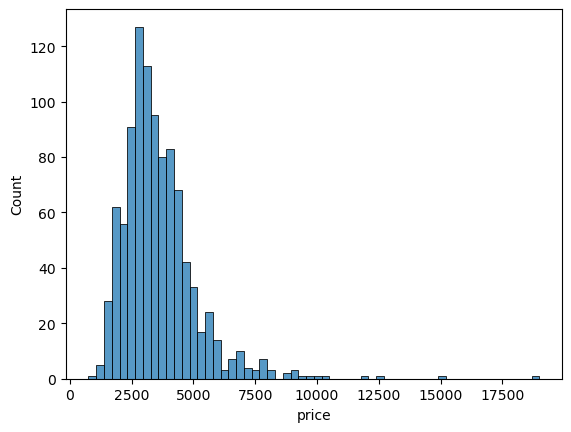

In [67]:
#checking target variable
sns.histplot(rentals_df['price'])

<Axes: xlabel='laundry'>

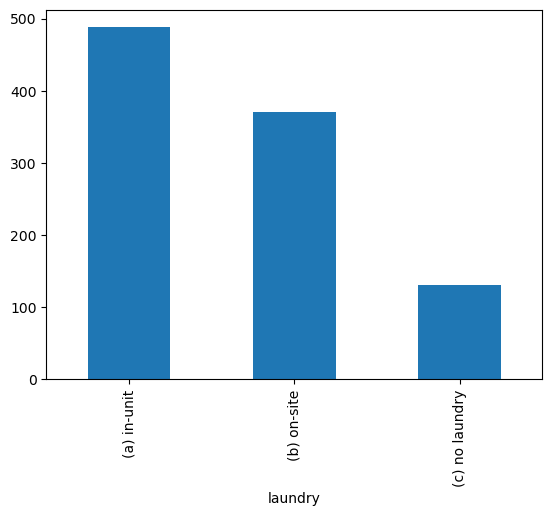

In [68]:
#checking categorical features
rentals_df['laundry'].value_counts().plot.bar()

<Axes: xlabel='laundry'>

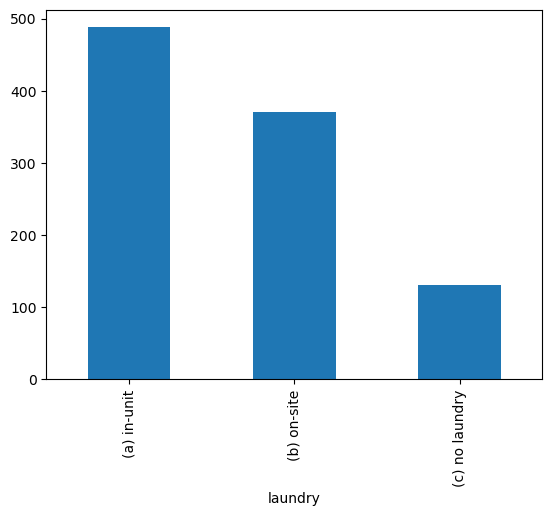

In [69]:
rentals_df['laundry'].value_counts().plot.bar()

<Axes: xlabel='pets'>

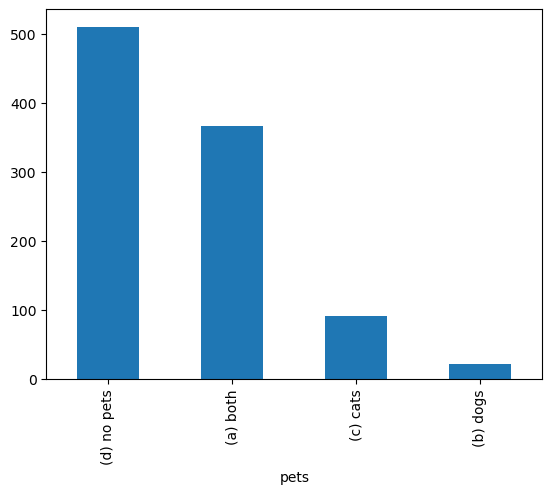

In [70]:
rentals_df['pets'].value_counts().plot.bar()

<Axes: xlabel='housing_type'>

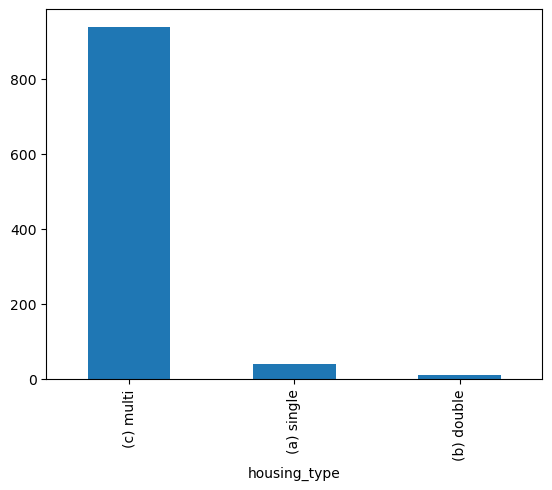

In [71]:
rentals_df['housing_type'].value_counts().plot.bar()

<Axes: xlabel='parking'>

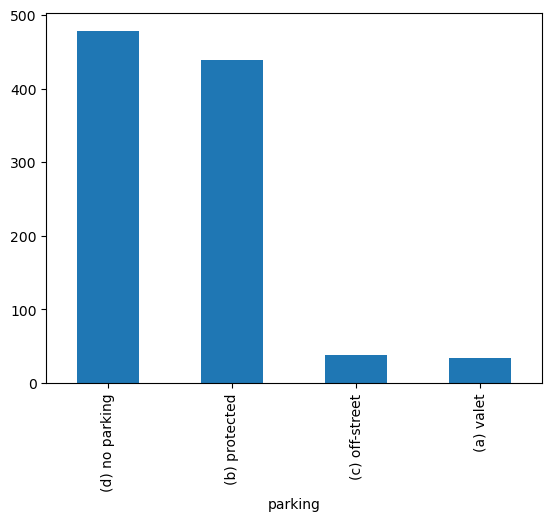

In [72]:
rentals_df['parking'].value_counts().plot.bar()

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

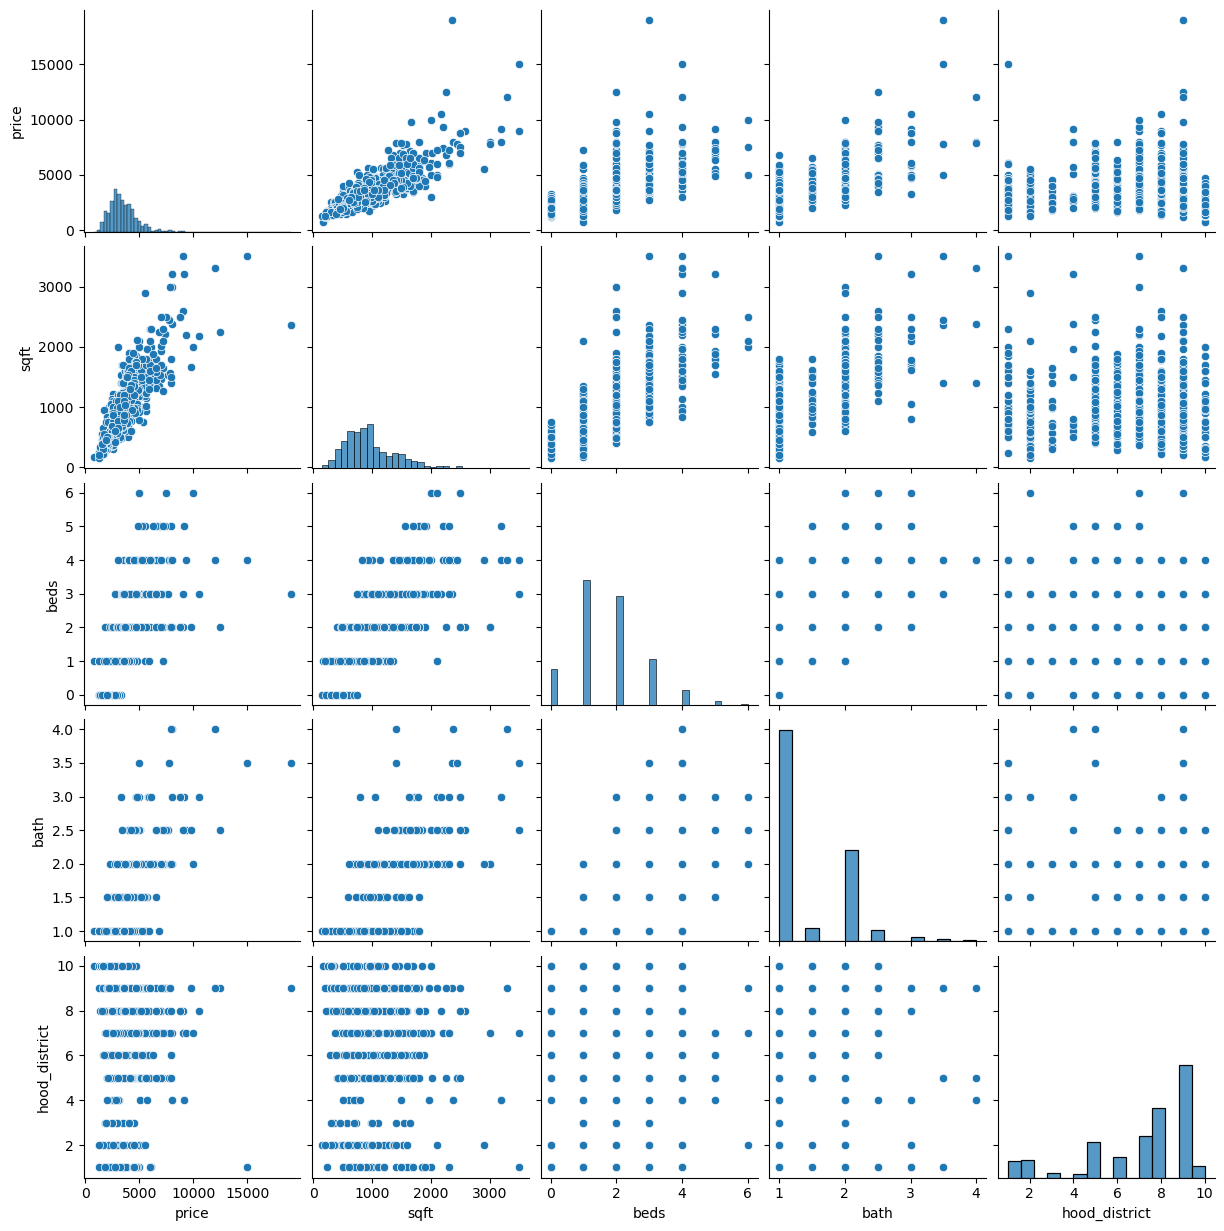

In [73]:
#checking numeric features
sns.pairplot(rentals_df)

<Axes: >

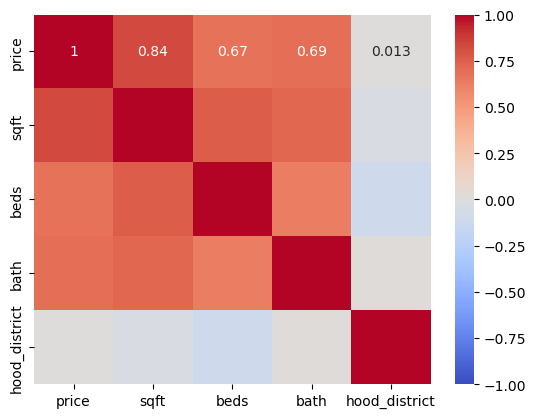

In [74]:
#according to this table we can see that sqft has the highest correlation with price.
#also number of beds and baths have high correlation with price
sns.heatmap(rentals_df.corr(numeric_only=True), vmin = -1, vmax = 1, cmap="coolwarm", annot=True)

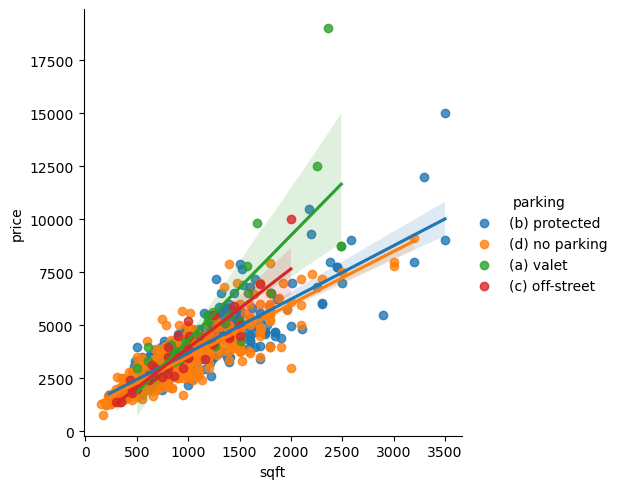

In [75]:
#this plot shows that houses which their parking is of valet type will grow faster than other houses.
#so we could use that as a feature
sns.lmplot(data=rentals_df, x='sqft', y='price', hue='parking')

## Feature Engineering

In [142]:
rentals_df['is_valet'] = np.where(rentals_df['parking'] == '(a) valet', 1, 0)
rentals_df[rentals_df.parking == '(a) valet'].head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district,is_valet
47,3800,950.0,1.0,1.0,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0,1
55,4050,830.0,1.0,1.0,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0,1
64,2399,559.0,1.0,1.0,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0,1
220,4242,981.0,2.0,2.0,(a) in-unit,(a) both,(c) multi,(a) valet,9.0,1
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0,1


In [143]:
#we can use the sum of number of baths and beds as an important feature in our model
rentals_df['beds_bath_sum'] = rentals_df['beds'] + rentals_df['bath']
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district,is_valet,beds_bath_sum
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0,0,4.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0,0,2.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0,0,3.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0,0,5.5
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0,0,2.0


## Data Splitting

In [144]:
X = rentals_df[['sqft', 'beds_bath_sum', 'is_valet']]
Y = rentals_df['price']

In [145]:
#we will use cross validation for validating different models
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

## Scaling Data

In [146]:
std = StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X.values), columns=X.columns)
X_test_std = pd.DataFrame(std.transform(X_test.values), columns=X.columns)

## Linear Regression

In [137]:
def r2_calculation(X_std, Y, cv_r2_train_scores, cv_r2_valid_scores):
    for train_indices, valid_indices in kf.split(X_std, Y):
        X_train_std = X_std.iloc[train_indices, :]
        Y_train = Y.iloc[train_indices]
        X_valid_std = X_std.iloc[valid_indices, :]
        Y_valid = Y.iloc[valid_indices]
        model = LinearRegression()
        model.fit(X_train_std, Y_train)
        cv_r2_valid_scores.append(r2(Y_valid, model.predict(X_valid_std)))
        cv_r2_train_scores.append(r2(Y_train, model.predict(X_train_std)))

In [138]:
kf = KFold(n_splits=5, shuffle=True, random_state=1403)
cv_r2_train_scores, cv_r2_valid_scores = [], []
r2_calculation(X_std, Y, cv_r2_train_scores, cv_r2_valid_scores)
print(f'training data r2 score: {np.mean(cv_r2_train_scores)}')
print(f'validation data r2 score: {np.mean(cv_r2_valid_scores)}')

training data r2 score: 0.7256653374643064
validation data r2 score: 0.7165020001225033


## Ridge

In [147]:
n_alphas = 200
alphas = 10 ** np.linspace(3, -3, n_alphas)
model = RidgeCV(alphas=alphas)
model.fit(X_std, Y)
print(f'best alpha: {model.alpha_}')

best alpha: 4.768611697714469


In [148]:
#after runnig this code we can see that training r2 score decreases and validation r2 score increases compared with linear regression
model = Ridge(alpha=4.768611697714469)
cv_results = cross_validate(model, X_std, Y, cv=5, scoring='r2', return_train_score=True)
print(f"training data r2 score: {cv_results['train_score'].mean()}")
print(f"validation data r2 score: {cv_results['test_score'].mean()}")

training data r2 score: 0.7247622579848431
validation data r2 score: 0.7188267835558955


## Lasso

In [149]:
n_alphas = 200
alphas = 10 ** np.linspace(3, -3, n_alphas)
model = LassoCV(alphas=alphas)
model.fit(X_std, Y)
print(f'best alpha: {model.alpha_}')

best alpha: 5.872786613189483


In [150]:
model = Lasso(alpha=5.872786613189483)
cv_results = cross_validate(model, X_std, Y, cv=5, scoring='r2', return_train_score=True)
print(f"training data r2 score: {cv_results['train_score'].mean()}")
print(f"validation data r2 score: {cv_results['test_score'].mean()}")

training data r2 score: 0.7247724372352315
validation data r2 score: 0.7185233867665588


## ENET

In [157]:
n_alphas = 200
alphas = 10 ** np.linspace(3, -3, n_alphas)
l1_ratio = np.linspace(0.1, 1, 10)
model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, max_iter=10000)
model.fit(X_std, Y)
print(f'best alpha: {model.alpha_}')
print(f'best l1_ratio: {model.l1_ratio_}')

best alpha: 0.032176417502507354
best l1_ratio: 0.2


In [158]:
model = ElasticNet(alpha=0.032176417502507354, l1_ratio=0.2, max_iter=10000)
cv_results = cross_validate(model, X_std, Y, cv=5, scoring='r2', return_train_score=True)
print(f"training data r2 score: {cv_results['train_score'].mean()}")
print(f"validation data r2 score: {cv_results['test_score'].mean()}")

training data r2 score: 0.7243883783416754
validation data r2 score: 0.7197631601371608


## Final Model Test

In [159]:
#at last we can see that elastic net had the best results. but also it didn't make our model that better. so for more interpretability we can stick to linear regression
model = LinearRegression()
model.fit(X_std, Y)
print(f'training data r2 score: {r2(Y, model.predict(X_std))}')
print(f'test data r2 score: {r2(Y_test, model.predict(X_test_std))}')

training data r2 score: 0.7230952640027672
test data r2 score: 0.7488245132440914
